# Time Series Prediction

In [48]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
import json

In [13]:
# Read in feature data
with open('feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None 
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Shape input features: (110, 40)


In [14]:
# Read in emission data
emission_data = pd.read_csv(
    "oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv")
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (110,)


In [15]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# TODO: Shuffle windows
	return np.array(dataX), np.array(dataY)

In [54]:
scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

(70, 12)
(70, 6)
(4, 12)
(4, 6)


## Create Datasets

### Input: Features

In [66]:
# # Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

### Input: Emissions

In [ ]:
# # Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [67]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(70, 12, 40)
(70, 6)
(4, 12, 40)
(4, 6)


## Multilayer Perceptron Regression

In [59]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    model = Sequential()
    # TODO: Try 1-D Conv instead of Dense (send JK beforehand)
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(24, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [68]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/400
 - 0s - loss: 4663.8792
Epoch 2/400
 - 0s - loss: 4103.1342
Epoch 3/400
 - 0s - loss: 2813.4944
Epoch 4/400
 - 0s - loss: 1814.0271
Epoch 5/400
 - 0s - loss: 1071.3284
Epoch 6/400
 - 0s - loss: 704.1292


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 7/400
 - 0s - loss: 437.3211
Epoch 8/400
 - 0s - loss: 237.1266
Epoch 9/400
 - 0s - loss: 111.1563
Epoch 10/400
 - 0s - loss: 48.5903
Epoch 11/400
 - 0s - loss: 23.9820
Epoch 12/400
 - 0s - loss: 20.1480
Epoch 13/400
 - 0s - loss: 18.2546
Epoch 14/400
 - 0s - loss: 16.8858
Epoch 15/400
 - 0s - loss: 15.9126
Epoch 16/400
 - 0s - loss: 15.1299
Epoch 17/400
 - 0s - loss: 14.2547
Epoch 18/400
 - 0s - loss: 13.5364
Epoch 19/400
 - 0s - loss: 12.8168
Epoch 20/400
 - 0s - loss: 12.4838
Epoch 21/400
 - 0s - loss: 11.7676
Epoch 22/400
 - 0s - loss: 11.1260
Epoch 23/400
 - 0s - loss: 9.9821
Epoch 24/400
 - 0s - loss: 9.3121
Epoch 25/400
 - 0s - loss: 8.3871
Epoch 26/400
 - 0s - loss: 7.2876
Epoch 27/400
 - 0s - loss: 6.4243
Epoch 28/400
 - 0s - loss: 5.2136
Epoch 29/400
 - 0s - loss: 4.1693
Epoch 30/400
 - 0s - loss: 3.4197
Epoch 31/400
 - 0s - loss: 2.8386
Epoch 32/400
 - 0s - loss: 2.4261
Epoch 33/400
 - 0s - loss: 2.1680
Epoch 34/400
 - 0s - loss: 1.9300
Epoch 35/400
 - 0s - loss: 1.856

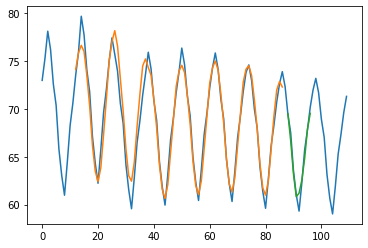

In [61]:
# Plot baseline and predictions - INPUT: EMISSIONS
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.show()

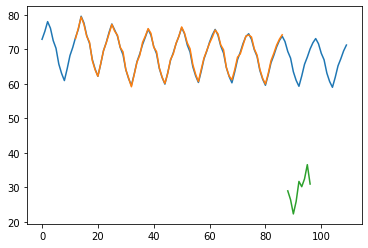

In [69]:
# Plot baseline and predictions - INPUT: FEATURES
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.show()

In [ ]:
import pickle

# Save variables
with open('mlp.pkl', 'wb') as f:
    pickle.dump([model, trainPredictPlot, testPredictPlot], f)

# Getting back the objects:
# with open('mlp.pkl', 'rb') as f:
#     model, trainPlot, testPlot = pickle.load(f)

In [64]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

### Plot with emissions as input

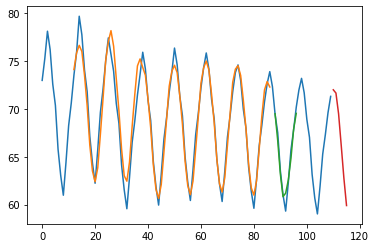

In [65]:
# Emissions
X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()

### Plot with features as input

Forecast: [[26.350094 35.040504 28.283737 28.475052 31.891432 26.299831]]


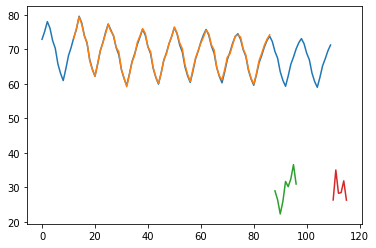

In [70]:
# Features
X = np.zeros((1, look_back, feature_data.shape[1]))
X[0] = feature_data[len(feature_data)-look_back:, :]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()